## Import and Process Data

Files already downloaded and verified
Files already downloaded and verified


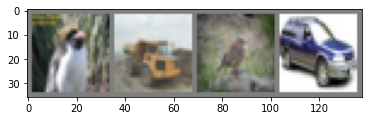

 bird truck  bird   car


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 4,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Basic CNN

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## MobileNet v2

### Source
https://github.com/tinyalpha/mobileNet-v2_cifar10/blob/master/network.py

In [3]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class Bottleneck(nn.Module):
    alpha = 1
    
    def __init__(self, input_channel, output_channel, t=6, downsample=False):
        """
        t: expansion factor, t*input_channel is channel of expansion layer
        alpha: width multiplier, to get thinner models
        rho: resolution multiplier, to get reduced representation
        """
        super(Bottleneck, self).__init__()
        self.stride = 2 if downsample else 1
        self.downsample = downsample
        self.shortcut = (not downsample) and (input_channel == output_channel)
        
        input_channel = int(self.alpha * input_channel)
        output_channel = int(self.alpha * output_channel)
        
        # BOTTLENECK Components
        c = t * input_channel
        # 1 x 1 pointwise convolution
        self.conv0 = nn.Conv2d(input_channel, c, kernel_size=1, bias=False)
        self.batch0 = nn.BatchNorm2d(c)
        # 3 x 3 depthwise convolution
        self.conv1 = nn.Conv2d(c, c, kernel_size=3, stride=self.stride, padding=1, groups=c, bias=False)
        self.batch1 = nn.BatchNorm2d(c)
        # 1 x 1 pointwise convolution
        self.conv2 = nn.Conv2d(c, output_channel, kernel_size=1, bias=False)
        self.batch2 = nn.BatchNorm2d(output_channel)
        
    def forward(self, inputs):
#         print("bottleneck layer", inputs != None)
        # BOTTLENECK
        x = F.relu6(self.batch0(self.conv0(inputs)), inplace=True)
        x = F.relu6(self.batch1(self.conv1(x)), inplace=True)
        x = self.batch2(self.conv2(x))
        
        # Shortcut
        x = x + inputs if self.shortcut else x
        
        return x
        
class MobileNetV2(nn.Module):
    def __init__(self, output_size, alpha=1):
        super(MobileNetV2, self).__init__()
        self.output_size = output_size

        # Initial convolution layer
        self.conv0 = nn.Conv2d(3, int(32*alpha), kernel_size=3, stride=1, padding=1, bias=False)
        self.batch0 = nn.BatchNorm2d(int(32*alpha))

        # Bottleneck layers
        self.bottlenecks = nn.Sequential(
            Bottleneck(32, 16, t=1, downsample=False),
            Bottleneck(16, 24, downsample=False),
            Bottleneck(24, 24),
            Bottleneck(24, 32, downsample=False),
            Bottleneck(32, 32),
            Bottleneck(32, 32),
            Bottleneck(32, 64, downsample=False),
            Bottleneck(64, 64),
            Bottleneck(64, 64),
            Bottleneck(64, 64),
            Bottleneck(64, 96, downsample=False),
            Bottleneck(96, 96),
            Bottleneck(96, 96),
            Bottleneck(96, 160, downsample=False),
            Bottleneck(160, 160),
            Bottleneck(160, 160),
            Bottleneck(160, 320, downsample=False)
        )

        # Final convolution layer
        self.conv1 = nn.Conv2d(int(320*alpha), 1280, kernel_size=1, bias=False)
        self.batch1 = nn.BatchNorm2d(1280)

        # Fully connected layer
        self.fc = nn.Linear(1280, output_size)
        
    def forward(self, inputs):
        # Convolution
        x = F.relu6(self.batch0(self.conv0(inputs)), inplace=True)
        # print(x != None)
        # Bottleneck
        x = self.bottlenecks(x)
        # Convolution
        x = F.relu6(self.batch1(self.conv1(x)), inplace=True)
        # Pool
        x = F.adaptive_avg_pool2d(x, 1)
        # Linear
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        

## Train

In [ ]:
net = MobileNetV2(10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
#         print(inputs != None)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

print("Training complete!")

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
print("File saved.")

## Test

In [ ]:
net = MobileNetV2()
net.load_state_dict(torch.load(PATH))

outputs = net(images)
print(outputs)

_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))